Load HCP data and connectivity analysis.

# Tutorial PCA

# Data load

In [ ]:
# #%pip install google.colab
# #from google.colab import drive
# import os
# import requests
# import tarfile

# # Montar Google Drive
# #drive.mount('/content/drive')

# # Definir directorios y archivos
# #drive_dir = "/content/drive/My Drive/HCP_data"
# dir = r"C:\Users\cwako\OneDrive\NMA"
# os.makedirs(dir, exist_ok=True)
# fnames = ["hcp_rest.tgz",
#           "hcp_task.tgz",
#           "hcp_covariates.tgz",
#           "atlas.npz"]
# urls = ["https://osf.io/bqp7m/download",
#         "https://osf.io/s4h8j/download",
#         "https://osf.io/x5p4g/download",
#         "https://osf.io/j5kuc/download"]
# # Función para descargar archivos
# def download_file(url, fname):
#     try:
#         r = requests.get(url)
#         r.raise_for_status()  # Check for HTTP errors
#     except requests.ConnectionError:
#         print("!!! Failed to download data: Connection Error !!!")
#     except requests.HTTPError as err:
#         print(f"!!! Failed to download data: HTTP Error {err} !!!")
#     else:
#         print(f"Downloading {fname}...")
#         with open(fname, "wb") as fid:
#             fid.write(r.content)
#         print(f"Download {fname} completed!")

# # Descargar los archivos si no existen en Google Drive
# for fname, url in zip(fnames, urls):
#     drive_path = os.path.join(dir, fname)
#     if not os.path.isfile(drive_path):
#         download_file(url, drive_path)
#     else:
#         print(f"{fname} already exists in Google Drive.")

# # Si necesitas extraer los archivos
# def extract_file(filepath, extract_to):
#     if tarfile.is_tarfile(filepath):
#         with tarfile.open(filepath) as tar:
#             tar.extractall(path=extract_to)
#         print(f"Extracted {os.path.basename(filepath)} to {extract_to}")
#     else:
#         print(f"{os.path.basename(filepath)} is not a valid tar file.")

# for fname in fnames:
#     drive_path = os.path.join(dir, fname)
#     extract_file(drive_path, dir)


In [ ]:
from google.colab import drive
import os
import numpy as np

# Mount Google Drive
drive.mount('/content/drive')

# Define directory
drive_dir = "/content/drive/My Drive/HCP_data"
extracted_dirs = ["hcp_rest", "hcp_task", "hcp"]

# Define paths to extracted files
rest_path = os.path.join(drive_dir, extracted_dirs[0])
task_path = os.path.join(drive_dir, extracted_dirs[1])
covariates_path = os.path.join(drive_dir, extracted_dirs[2], "behavior")
atlas_path = os.path.join(drive_dir, "atlas.npz")

# Load the atlas file
with np.load(atlas_path) as dobj:
    atlas = dict(**dobj)

# Your code to work with the extracted data
# For example, list files in the directories
rest_files = os.listdir(rest_path)
task_files = os.listdir(task_path)
covariates_files = os.listdir(covariates_path)

print("Resting-state fMRI files:", rest_files)
print("Task-based fMRI files:", task_files)
print("Covariates files:", covariates_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Resting-state fMRI files: ['regions.npy', 'subjects']
Task-based fMRI files: ['regions.npy', 'subjects']
Covariates files: ['gambling.csv', 'language.csv', 'emotion.csv', 'wm.csv', 'relational.csv', 'social.csv']


In [ ]:
%pip install numpy
%pip install pyplot
%pip install nilearn --quiet
%pip install matplotlib

ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import plotting, datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
import seaborn as sns


In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "/content/drive/My Drive/HCP_data"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# MATRIX LOADING

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
             i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
             ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}'")
  return run_ids


def load_timeseries(subject, name, dir,
                    runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    dir (str) : data directory
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
               load_single_timeseries(subject,
                                      offset + run,
                                      dir,
                                      remove_mean) for run in runs
               ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, dir, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    dir (str) : data directory
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = os.path.join(dir, "subjects", str(subject), "timeseries")
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(os.path.join(bold_path, bold_file))
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, name, condition, dir):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition
    dir (str) : data directory

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = os.path.join(dir, "subjects", str(subject), "EVs",
                           task_key, f"{condition}.txt")
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools,
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

## Load individual runs for a given task

Load each subject's data for a specific task, separately for each run:

In [ ]:
timeseries_task = []
for subject in subjects:
  ts_concat_task = load_timeseries(subject, name="language", dir=os.path.join(HCP_DIR, "hcp_task"))
  timeseries_task.append(ts_concat_task)
  # print(timeseries_task.shape)  # n_parcel x n_timepoint

#Construct functional connectivity matrix (FC_task) for task_based analysis


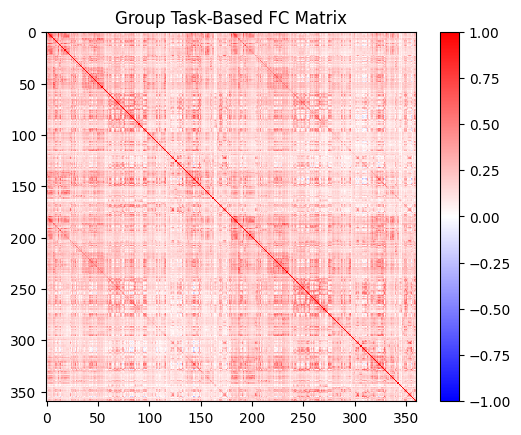

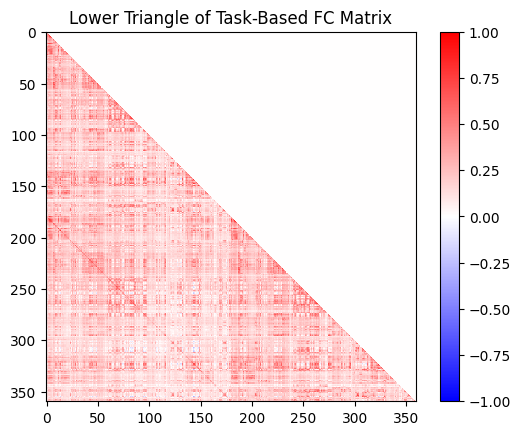

In [ ]:
# Construct the task-based FC matrix for STORY task
task_fc_matrix = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_task):
    task_fc_matrix[sub] = np.corrcoef(ts)

group_task_fc = task_fc_matrix.mean(axis=0)

plt.figure()
plt.imshow(group_task_fc, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.title('Group Task-Based FC Matrix')
plt.show()

# Extract the lower triangle for analysis
lower_triangle_task = np.tril(task_fc_matrix, k=-1)
group_task_fc_lower = lower_triangle_task.mean(axis=0)

plt.figure()
plt.imshow(group_task_fc_lower, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.title('Lower Triangle of Task-Based FC Matrix')
plt.show()

## Run a simple subtraction analysis

In [ ]:
# task = "language"
# conditions = ["response_story"]  # Run a one sample analysis for story

# contrast = []
# for subject in subjects:

#   # Get the average signal in each region for each condition
#   evs = [load_evs(subject, task, cond, dir=os.path.join(HCP_DIR, "hcp_task")) for cond in conditions]
#   avgs = [selective_average(timeseries_task[subject], ev) for ev in evs]

#   # Store the region-wise difference
#   contrast.append(avgs[0])

# group_contrast_task = np.mean(contrast, axis=0)

# Average difficulty vector

<ipython-input-54-12e322ec5b88>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  avg_dif_df['Label'] = (avg_dif_df['AVG_DIFFICULTY_LEVEL'] > threshold).astype(int)


     Subject  AVG_DIFFICULTY_LEVEL  Label
0          0              8.892857      0
1          1             10.089286      0
2          2             10.053571      0
3          3              8.767857      0
4          4              9.357143      0
..       ...                   ...    ...
334      334             12.446429      1
335      335              8.750000      0
336      336              9.464286      0
337      337             11.178571      1
338      338              9.375000      0

[339 rows x 3 columns]


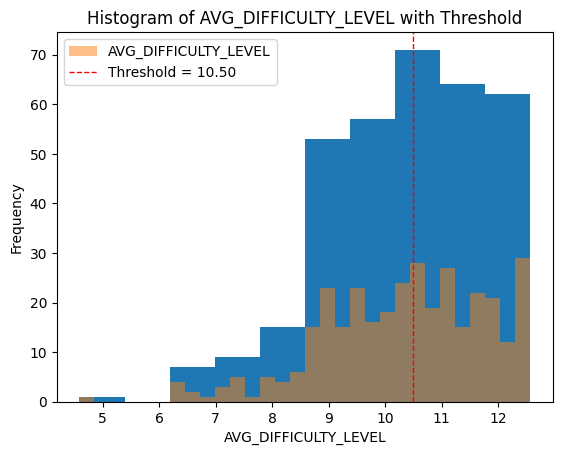

[0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1
 0 0 1 1 1 1 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1
 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 0
 0 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 1 1 0
 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0
 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1
 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0
 0 1 0 0 1 0]


In [ ]:
language_df = pd.read_csv(os.path.join(covariates_path, "language.csv"))
filtered_df = language_df[language_df['ConditionName'] == 'STORY']
run_mean = filtered_df.groupby('Subject')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean().reset_index()

avg_dif_df = run_mean[['Subject', 'AVG_DIFFICULTY_LEVEL']]

avg_dif_df.head()

#plt.hist(run_mean['ACC'])
plt.hist(run_mean['AVG_DIFFICULTY_LEVEL'])

# Define the threshold
threshold = 10.5

# Function to assign the labels, if value in the column is above the threshold Ture, as tyoe converts boolean into binary numbers (0, 1)
avg_dif_df['Label'] = (avg_dif_df['AVG_DIFFICULTY_LEVEL'] > threshold).astype(int)
print(avg_dif_df)

# Histogram of average difficulty
plt.hist(avg_dif_df['AVG_DIFFICULTY_LEVEL'], bins=30, alpha=0.5, label='AVG_DIFFICULTY_LEVEL')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold = {threshold:.2f}')
plt.xlabel('AVG_DIFFICULTY_LEVEL')
plt.ylabel('Frequency')
plt.title('Histogram of AVG_DIFFICULTY_LEVEL with Threshold')
plt.legend()
plt.show()

# Vector de etiquetas
labels_vector = avg_dif_df['Label'].values
print(labels_vector)

In [ ]:
print(max(avg_dif_df['AVG_DIFFICULTY_LEVEL']))
print(min(avg_dif_df['AVG_DIFFICULTY_LEVEL']))

12.57142857145
4.589285714285


# Accuracy vectors

<ipython-input-56-852c2c7684d4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accuracy_m['Label'] = (accuracy_m['ACC'] > threshold).astype(int)


     Subject    ACC  Label
0          0  0.875      1
1          1  1.000      1
2          2  1.000      1
3          3  0.750      0
4          4  0.875      1
..       ...    ...    ...
334      334  1.000      1
335      335  0.875      1
336      336  0.875      1
337      337  1.000      1
338      338  1.000      1

[339 rows x 3 columns]


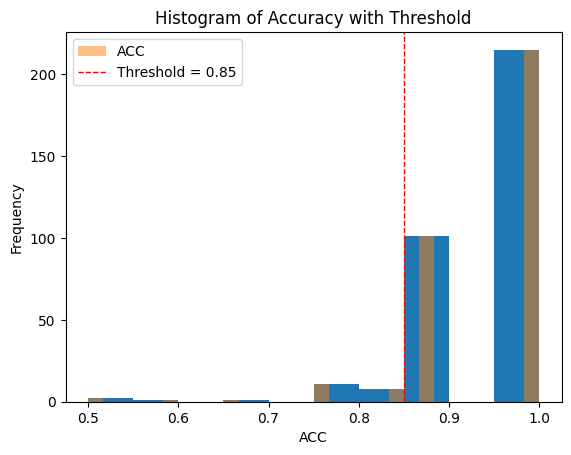

[1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]


In [ ]:
filtered_df = language_df[language_df['ConditionName'] == 'STORY']
run_mean = filtered_df.groupby('Subject')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean().reset_index()

accuracy_m = run_mean[['Subject', 'ACC']]

accuracy_m.head()

#plt.hist(run_mean['ACC'])
plt.hist(run_mean['ACC'])

# Define the threshold
threshold = 0.85

# Function to assign the labels, if value in the column is above the threshold Ture, as tyoe converts boolean into binary numbers (0, 1)
accuracy_m['Label'] = (accuracy_m['ACC'] > threshold).astype(int)
print(accuracy_m)

# Histogram of average difficulty
plt.hist(accuracy_m['ACC'], bins=30, alpha=0.5, label='ACC')
plt.axvline(threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold = {threshold:.2f}')
plt.xlabel('ACC')
plt.ylabel('Frequency')
plt.title('Histogram of Accuracy with Threshold')
plt.legend()
plt.show()

# Vector de etiquetas
labels_vector_acc = accuracy_m['Label'].values
print(labels_vector_acc)

# PCA

In [ ]:
# Assuming you have already calculated the group connectivity matrix
# group_fc has dimensions(N_PARCELS, N_PARCELS)

# Flatten the functional connectivity matrix for each subject
lower_triangle_indices = np.tril_indices(N_PARCELS, k=-1)


flat_fc_task = [fc[lower_triangle_indices] for fc in lower_triangle_task]

# Convert to a numpy array
flat_fc_task = np.array(flat_fc_task)

print(flat_fc_task.shape)  # Should be (N_SUBJECTS, N_PARCELS*(N_PARCELS-1)/2)


(339, 64620)


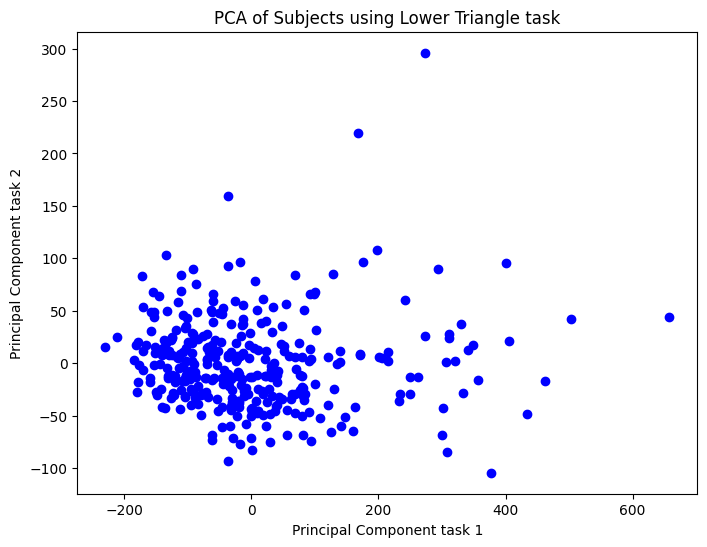

[[ 0.00441813  0.00272626  0.00392844 ...  0.00249919  0.00446071
   0.0045045 ]
 [-0.00176521 -0.00894234 -0.00427137 ... -0.00582909  0.00529891
   0.00162449]
 [ 0.00588723  0.00407135  0.00530128 ... -0.00185489 -0.00360201
  -0.00485262]
 ...
 [-0.00555613 -0.00587779 -0.00489307 ... -0.00246688 -0.00107212
  -0.00456295]
 [ 0.00119842  0.00246837 -0.001467   ...  0.00723902 -0.00108229
  -0.00231605]
 [-0.00343241 -0.00278874  0.00424791 ... -0.00595666  0.00264742
  -0.00121725]]


In [104]:
# Step 2: Standardize the data
scaler_task = StandardScaler()
standardized_data_task = scaler_task.fit_transform(flat_fc_task)

# Step 3: Perform PCA
pca_task = PCA(50)  # You can adjust the number of components
principal_components_task = pca_task.fit_transform(standardized_data_task)

# Step 4: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(principal_components_task[:, 0], principal_components_task[:, 1], c='blue')
plt.xlabel('Principal Component task 1')
plt.ylabel('Principal Component task 2')
plt.title('PCA of Subjects using Lower Triangle task')
plt.show()

# Explained variance
explained_variance_task = pca_task.explained_variance_ratio_
weights_task = pca_task.components_
print(weights_task)


In [97]:
print(principal_components_task.shape)

(339, 25)


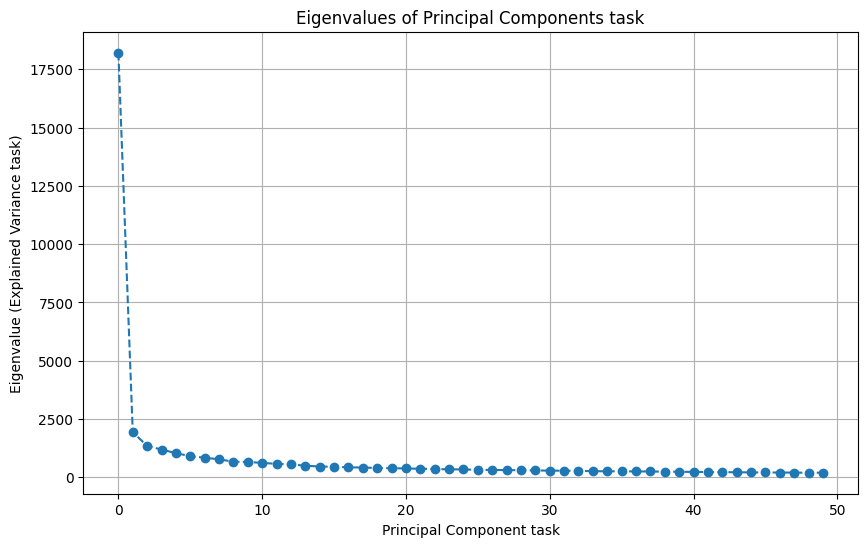

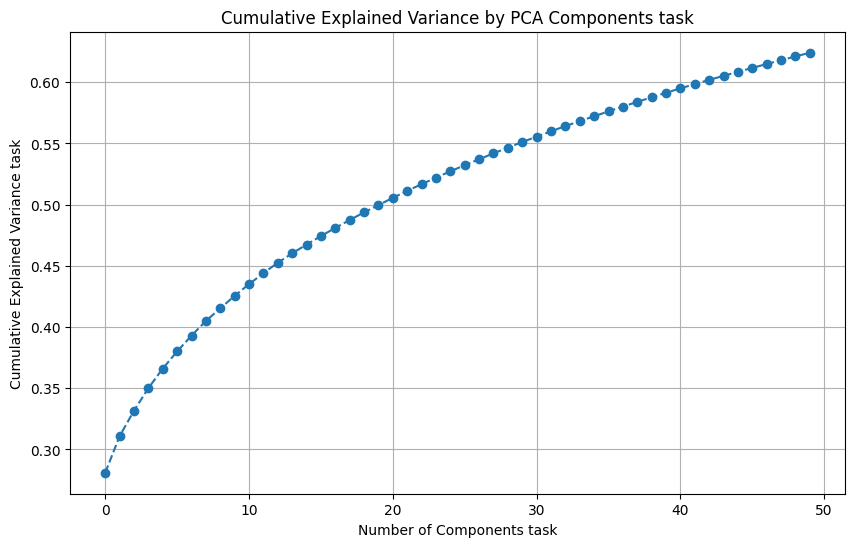

In [105]:
# # # Explained variance
explained_variance_task = pca_task.explained_variance_
explained_variance_ratio_task = pca_task.explained_variance_ratio_

# # # Plot eigenvalues (explained variance)
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_task, marker='o', linestyle='--')
plt.xlabel('Principal Component task')
plt.ylabel('Eigenvalue (Explained Variance task)')
plt.title('Eigenvalues of Principal Components task')
plt.grid(True)
plt.show()

# # # Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio_task), marker='o', linestyle='--')
plt.xlabel('Number of Components task')
plt.ylabel('Cumulative Explained Variance task')
plt.title('Cumulative Explained Variance by PCA Components task')
plt.grid(True)
plt.show()

In [106]:
explained_variance_task = pca_task.explained_variance_ratio_
weights_task = pca_task.components_
print(weights_task.shape)
weights_transposed_task = weights_task.T

# Create a DataFrame
weights_df_task = pd.DataFrame(weights_transposed_task, columns=[f"PC{i+1}" for i in range(weights_task.shape[0])], index=range(1, weights_task.shape[1] + 1))

print(weights_df_task)
print(max(weights_df_task))

(50, 64620)
            PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
1      0.004418 -0.001765  0.005887  0.000573 -0.001701  0.002380 -0.000659   
2      0.002726 -0.008942  0.004071 -0.000646  0.004568 -0.003369 -0.003584   
3      0.003928 -0.004271  0.005301  0.002178 -0.006366 -0.002394 -0.000565   
4      0.003406 -0.005250  0.005483 -0.000192  0.005038  0.003440  0.000742   
5      0.004340 -0.000505  0.005658  0.001199 -0.006345  0.002334  0.001752   
...         ...       ...       ...       ...       ...       ...       ...   
64616  0.004780  0.001159 -0.003020 -0.005807  0.000108  0.002178 -0.006622   
64617  0.003987  0.008481 -0.003152 -0.004770 -0.005101  0.002527 -0.005117   
64618  0.002499 -0.005829 -0.001855 -0.005668  0.004712 -0.003579 -0.004518   
64619  0.004461  0.005299 -0.003602 -0.002988  0.001817  0.005237 -0.004468   
64620  0.004505  0.001624 -0.004853  0.001183  0.001083  0.006602 -0.000193   

            PC8       PC9      PC10  ..

In [107]:
explained_variance_ratio_task = pca_task.explained_variance_ratio_

# Print the explained variance ratio for each component
for i, ratio in enumerate(explained_variance_ratio_task):
    print(f"Component {i+1}: Explained Variance Ratio = {ratio:.8f}")

Component 1: Explained Variance Ratio = 0.28098293
Component 2: Explained Variance Ratio = 0.02993791
Component 3: Explained Variance Ratio = 0.02076194
Component 4: Explained Variance Ratio = 0.01839324
Component 5: Explained Variance Ratio = 0.01601734
Component 6: Explained Variance Ratio = 0.01397182
Component 7: Explained Variance Ratio = 0.01294798
Component 8: Explained Variance Ratio = 0.01195178
Component 9: Explained Variance Ratio = 0.01032238
Component 10: Explained Variance Ratio = 0.01022676
Component 11: Explained Variance Ratio = 0.00950897
Component 12: Explained Variance Ratio = 0.00896130
Component 13: Explained Variance Ratio = 0.00852281
Component 14: Explained Variance Ratio = 0.00770172
Component 15: Explained Variance Ratio = 0.00712740
Component 16: Explained Variance Ratio = 0.00700603
Component 17: Explained Variance Ratio = 0.00661590
Component 18: Explained Variance Ratio = 0.00647750
Component 19: Explained Variance Ratio = 0.00617174
Component 20: Explain

we can try to do a linear regression to predict the avg_difficult instead of a clasiffier and we won't need the labels

# The model starts here

In [116]:
avg_dif_df

,Subject,AVG_DIFFICULTY_LEVEL,Label
0,0,8.892857,0
1,1,10.089286,0
2,2,10.053571,0
3,3,8.767857,0
4,4,9.357143,0
...,...,...,...
334,334,12.446429,1
335,335,8.750000,0
336,336,9.464286,0
337,337,11.178571,1


In [88]:
# principal_components_task

# try other models
random forest, decision making trees, svm,
feature selection (other than pca)
knearest neighbour


# Model on Average difficulty

In [108]:
# Assuming principal_components is your feature data and y is your target variable
X = principal_components_task
y = labels_vector  # Replace with your actual target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Initialize the classifier
classifier = LogisticRegression(random_state=42, solver = "liblinear")

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:')
print(report)

matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(matrix)


Accuracy: 0.6617647058823529
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        30
           1       0.78      0.55      0.65        38

    accuracy                           0.66        68
   macro avg       0.68      0.68      0.66        68
weighted avg       0.69      0.66      0.66        68

Confusion Matrix:
[[24  6]
 [17 21]]


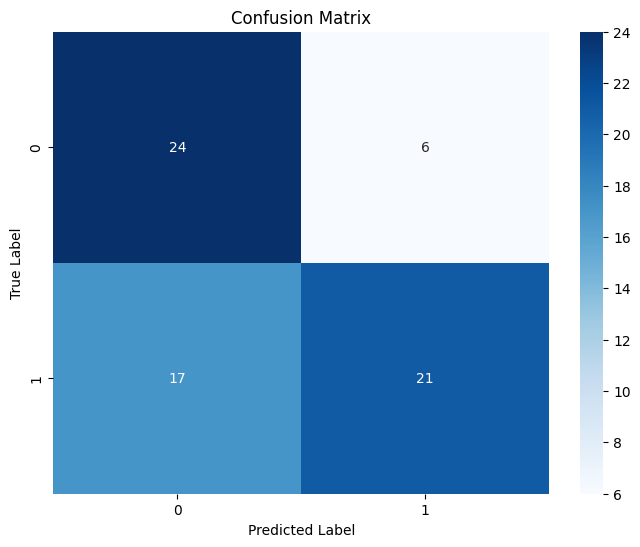

In [109]:
# Compute the confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [115]:
%pip install statsmodels --quiet
from statsmodels import api as sm
log_reg_model = sm.OLS(y_train, X_train).fit()
print(log_reg_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.212
Model:                            OLS   Adj. R-squared (uncentered):              0.034
Method:                 Least Squares   F-statistic:                              1.191
Date:                Wed, 24 Jul 2024   Prob (F-statistic):                       0.198
Time:                        14:00:01   Log-Likelihood:                         -246.26
No. Observations:                 271   AIC:                                      592.5
Df Residuals:                     221   BIC:                                      772.6
Df Model:                          50                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Models on Accuracy

In [121]:
# X_acc = principal_components_task
# y_acc = labels_vector_acc  # Replace with your actual target variable

# # Split the data into training and testing sets
# X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(X_acc, y_acc, test_size=0.2, train_size=0.8, random_state=42)
# model = LogisticRegression(solver = "liblinear")
# model.fit(X_train_acc, y_train_acc)

# y_pred_train_acc = model.predict(X_train_acc)
# y_pred_test_acc = model.predict(X_test_acc)

# mse_train_acc = mean_squared_error(y_train, y_pred_train_acc)
# mse_test_acc = mean_squared_error(y_test, y_pred_test_acc)

# print(f"MSE train:{mse_train_acc}")
# print(f"MSE test:{mse_test_acc}")

# classifier = LogisticRegression(random_state=42, solver = "liblinear")

# # Train the classifier
# classifier.fit(X_train_acc, y_train_acc)

# # Make predictions
# y_pred_acc = classifier.predict(X_test_acc)

# # Evaluate the classifier
# accuracy_acc = accuracy_score(y_test_acc, y_pred_acc)
# print(f'Accuracy: {accuracy_acc}')

# report_acc = classification_report(y_test_acc, y_pred_acc)
# print('Classification Report:')
# print(report_acc)

# matrix_acc = confusion_matrix(y_test_acc, y_pred_acc)
# print('Confusion Matrix:')
# print(matrix_acc)

In [122]:
# # Compute the confusion matrix
# matrix_acc = confusion_matrix(y_test_acc, y_pred_acc)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(matrix_acc, annot=True, fmt='d', cmap='Blues', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()


# Model Validation

k fold validation,

In [125]:
# Perform cross-validation
cv_scores = cross_val_score(classifier, X, y, cv=5)

print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV score: {cv_scores.mean()}')


Cross-validation scores: [0.55882353 0.75       0.63235294 0.73529412 0.56716418]
Mean CV score: 0.6487269534679544


# Feature Importance

Feature Importance:
Feature 48: 0.08866224139255321
Feature 13: 0.06683557099405904
Feature 20: 0.048039985067676275
Feature 37: 0.04501759401677322
Feature 14: 0.043563717792853736
Feature 24: 0.03637615698834977
Feature 22: 0.03493457544355825
Feature 8: 0.033439480048821246
Feature 17: 0.030675957280460308
Feature 38: 0.030560634917194292
Feature 21: 0.029128608311954216
Feature 16: 0.028719699379670515
Feature 36: 0.028458495728637265
Feature 39: 0.02486229340294151
Feature 35: 0.024265924762019685
Feature 49: 0.02217519211175693
Feature 29: 0.021671092166652448
Feature 5: 0.021417950559818905
Feature 30: 0.02137470695862846
Feature 33: 0.01954048915233031
Feature 10: 0.019434578927513997
Feature 45: 0.019343452008764594
Feature 12: 0.01904863839828996
Feature 44: 0.01847324273638335
Feature 47: 0.016518211199299762
Feature 42: 0.014399121017731999
Feature 19: 0.013756430750229798
Feature 46: 0.013490801894622985
Feature 3: 0.013425830293118033
Feature 27: 0.012390922369847292
Feat

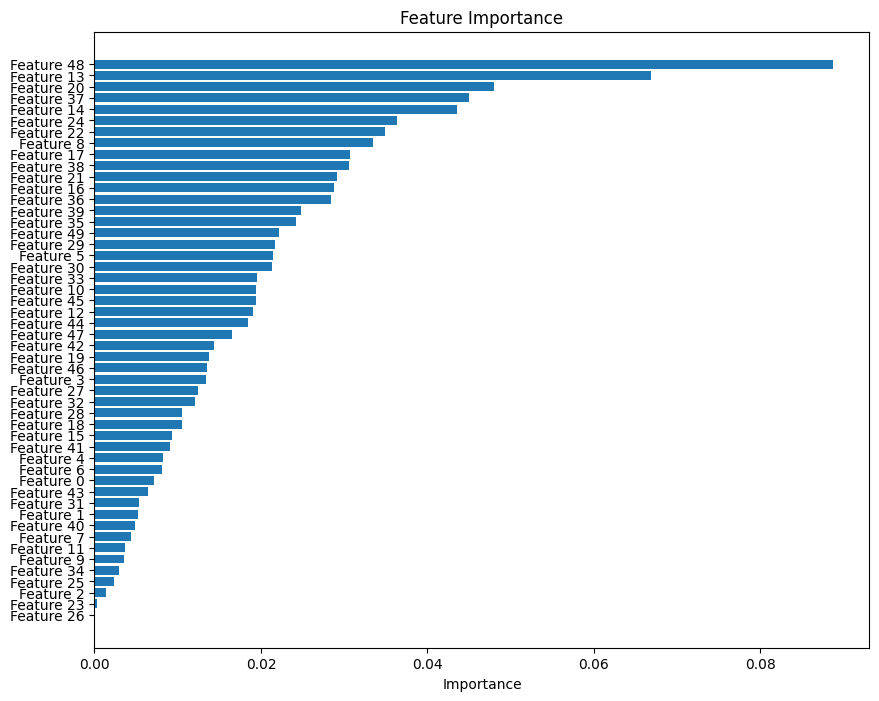

In [118]:
# Feature importance for logistic regression
if hasattr(classifier, 'coef_'):
    importance = np.abs(classifier.coef_[0])
    feature_names = [f'Feature {i}' for i in range(X.shape[1])]
    feature_importance = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)

    print('Feature Importance:')
    for feature, importance in feature_importance:
        print(f'{feature}: {importance}')

    # Plot feature importance
    feature_names, importances = zip(*feature_importance)
    plt.figure(figsize=(10, 8))
    plt.barh(feature_names, importances, align='center')
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert y axis to have the most important feature at the top
    plt.show()
else:
    print('The classifier does not have a `coef_` attribute.')

# XGboost


Accuracy_xgb: 0.6029411764705882


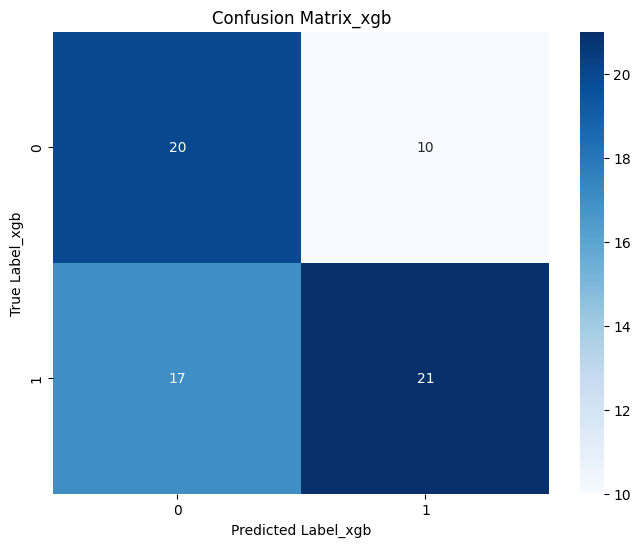

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        30
           1       0.68      0.55      0.61        38

    accuracy                           0.60        68
   macro avg       0.61      0.61      0.60        68
weighted avg       0.62      0.60      0.60        68



In [129]:
from xgboost import XGBClassifier

# Initialize the classifier
classifier_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the classifier
classifier_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = classifier_xgb.predict(X_test)

# Evaluate the classifier
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f'Accuracy_xgb: {accuracy_xgb}')

# Compute the confusion matrix
matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_xgb.classes_, yticklabels=classifier_xgb.classes_)
plt.xlabel('Predicted Label_xgb')
plt.ylabel('True Label_xgb')
plt.title('Confusion Matrix_xgb')
plt.show()

report = classification_report(y_test, y_pred_xgb)
print('Classification Report:')
print(report)

In [130]:
# Perform cross-validation for XGBOOST
cv_scores_xgb = cross_val_score(classifier_xgb, X, y, cv=5)

print(f'Cross-validation scores: {cv_scores_xgb}')
print(f'Mean CV score: {cv_scores_xgb.mean()}')


Cross-validation scores: [0.55882353 0.75       0.63235294 0.73529412 0.56716418]
Mean CV score: 0.6487269534679544


# Grid Search XGboost

In [120]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize the classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

# Use the best estimator to make predictions
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


KeyboardInterrupt: 

# elbow kmeans

In [ ]:
def visualize_components(component1, component2, labels, show=True):
  """
  Plots a 2D representation of the data for visualization with categories
  labelled as different colors.

  Args:
    component1 (numpy array of floats) : Vector of component 1 scores
    component2 (numpy array of floats) : Vector of component 2 scores
    labels (numpy array of floats)     : Vector corresponding to categories of
                                         samples

  Returns:
    Nothing.

  """

  plt.figure()
  plt.scatter(x=component1, y=component2, c=labels, cmap='tab10')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)
  if show:
    plt.show()

In [ ]:
dir = os.path.join(HCP_DIR, "hcp_rest")  # choose the data directory
regions = np.load(os.path.join(dir, "regions.npy")).T
region_info = dict(name=regions[0].tolist(),
                   network=regions[1],
                   myelin=regions[2].astype(float)
                   )
categories = region_info['network']
categories.shape

roi_to_category = {i: categories[i] for i in range(len(categories))}

print(roi_to_category)
n_participants, n_rois, _ = f_connectivity_matrix.shape
unique_categories = np.unique(categories)
n_categories = len(unique_categories)

# Create a mapping from category to its index
category_to_index = {cat: idx for idx, cat in enumerate(unique_categories)}

category_to_index

In [ ]:
print(categories.shape)

In [ ]:
new_fc = np.zeros((n_participants, n_categories, n_categories))

# Iterate through each participant
for p in range(n_participants):
    # Temporary matrix to hold aggregated values
    temp_matrix = np.zeros((n_categories, n_categories))
    count_matrix = np.zeros((n_categories, n_categories))  # To keep track of the number of values aggregated

    for i in range(n_rois):
        for j in range(n_rois):
            cat_i = category_to_index[categories[i]]
            cat_j = category_to_index[categories[j]]
            temp_matrix[cat_i, cat_j] += f_connectivity_matrix[p, i, j]
            count_matrix[cat_i, cat_j] += 1

    # Calculate the average connectivity by dividing the sum by the count
    temp_matrix = np.divide(temp_matrix, count_matrix, where=count_matrix!=0)  # Avoid division by zero
    new_fc[p] = temp_matrix

print(new_fc.shape)

In [ ]:
unique_categories = np.unique(categories)
colors = np.random.rand(len(unique_categories), 3)  # Generate random colors
network_to_color = dict(zip(unique_categories, colors))

all_labels = []

for fc in flat_fc:
    # Get ROI indices for the current connectivity matrix
    indices = np.tril_indices(N_PARCELS, k=-1)
    # Extract corresponding network labels
    labels = [roi_to_category[i] for i in indices[0]]  # Use row indices
    all_labels.extend(labels)

label_colors = [network_to_color[label] for label in all_labels]
label_colors = np.array(label_colors).reshape(flat_fc.shape)

In [ ]:
print(flat_fc.shape)
print(len(label_colors))
print(len(label_colors))
print(N_PARCELS)

In [ ]:
from sklearn.cluster import KMeans

# Using t-SNE results with perplexity=30 for clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
tsne_result = tsne.fit_transform(flat_fc)
#labels = [roi_to_category[i] for i in range(len(flat_fc))]
#print(labels)


# Visualize components using labels
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization')
plt.show()
# Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_result)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()



In [ ]:
print(tsne_result.shape)

In [ ]:
X_tnse = tsne_result
y = labels_vector  # Replace with your actual target variable

# Split the data into training and testing sets
X_train_tnse, X_test_tnse, y_train_tnse, y_test_tnse = train_test_split(X_tnse, y, test_size=0.2, train_size=0.8, random_state=42)

# Initialize the classifier
classifier = LogisticRegression(random_state=42, solver = "liblinear")

# Train the classifier
classifier.fit(X_train_tnse, y_train_tnse)

# Make predictions
y_pred_tnse = classifier.predict(X_test_tnse)

# Evaluate the classifier
accuracy_tnse = accuracy_score(y_test_tnse, y_pred_tnse)
print(f'Accuracy: {accuracy}')

report_tnse = classification_report(y_test_tnse, y_pred_tnse)
print('Classification Report:')
print(report_tnse)

matrix_tnse = confusion_matrix(y_test_tnse, y_pred_tnse)
print('Confusion Matrix:')
print(matrix_tnse)


In [ ]:
print(avg_dif_df.shape)

In [ ]:
from sklearn.linear_model import LinearRegression

y_avg = np.array(avg_dif_df['AVG_DIFFICULTY_LEVEL'])
print(y_avg.shape)
scaler = StandardScaler()
standardized_y_tsne = scaler.fit_transform(y_avg)

X_train_tnse, X_test_tnse, y_train_tnse, y_test_tnse = train_test_split(X_tnse, standardized_y_tsne, test_size=0.2, train_size=0.8, random_state=42)
model = LinearRegression()
model.fit(X_train_tnse, y_train_tnse)

# Make predictions on the test data
y_pred = model.predict(X_test_tnse)

# Evaluate the model
mse = mean_squared_error(y_test_tnse, y_pred_tnse)
print("Mean Squared Error:", mse)


# Random forest

Accuracy_task: 0.5147058823529411


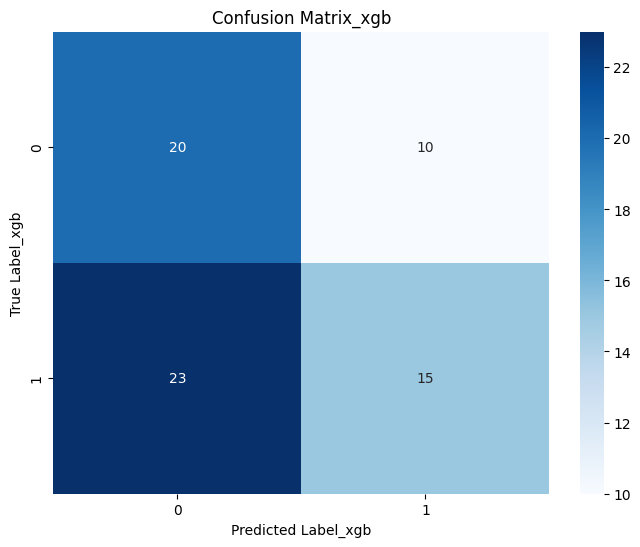

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.67      0.55        30
           1       0.60      0.39      0.48        38

    accuracy                           0.51        68
   macro avg       0.53      0.53      0.51        68
weighted avg       0.54      0.51      0.51        68



In [131]:
from sklearn.ensemble import RandomForestClassifier

# Assuming you have X_train, y_train, X_test, and y_test defined

# Create a Random Forest classifier
rf_classifier_task = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier_task.fit(X_train, y_train)

# Make predictions on the test data
y_pred_task_rf = rf_classifier_task.predict(X_test)

# Evaluate the model's performance
accuracy_task = accuracy_score(y_test, y_pred_task_rf)
print("Accuracy_task:", accuracy_task)

# Compute the confusion matrix
matrix_task_rf = confusion_matrix(y_test, y_pred_task_rf)
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_task_rf, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_xgb.classes_, yticklabels=classifier_xgb.classes_)
plt.xlabel('Predicted Label_xgb')
plt.ylabel('True Label_xgb')
plt.title('Confusion Matrix_xgb')
plt.show()

report = classification_report(y_test, y_pred_task_rf)
print('Classification Report:')
print(report)

# SVM

Accuracy_svm_task: 0.6470588235294118
Classification Report_svm_task:
              precision    recall  f1-score   support

           0       0.58      0.73      0.65        30
           1       0.73      0.58      0.65        38

    accuracy                           0.65        68
   macro avg       0.66      0.66      0.65        68
weighted avg       0.67      0.65      0.65        68



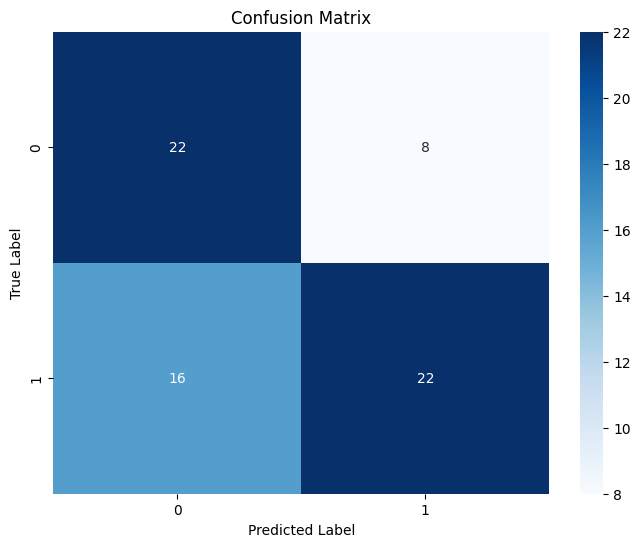

In [134]:
import numpy as np
# from sklearn.modelselection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# # Suponiendo que principal_components es tu conjunto de características y y es tu variable objetivo
# X = principal_components_task
# y = labels_vector  # Reemplaza con tu variable objetivo real

# # Dividir los datos en conjuntos de entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)

# Inicializar el clasificador SVM
classifier_svm_task = SVC(kernel='linear', random_state=42)

# Entrenar el clasificador
classifier_svm_task.fit(X_train, y_train)

# Hacer predicciones
y_pred_svm_task = classifier_svm_task.predict(X_test)

# Evaluar el clasificador
accuracy_svm_task = accuracy_score(y_test, y_pred_svm_task)
print(f'Accuracy_svm_task: {accuracy_svm_task}')

report_svm_task = classification_report(y_test, y_pred_svm_task)
print('Classification Report_svm_task:')
print(report_svm_task)

# Matriz de confusión
matrix_svm_task = confusion_matrix(y_test, y_pred_svm_task)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix_svm_task, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_svm_task.classes_, yticklabels=classifier_svm_task.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



# AUC-ROC plots

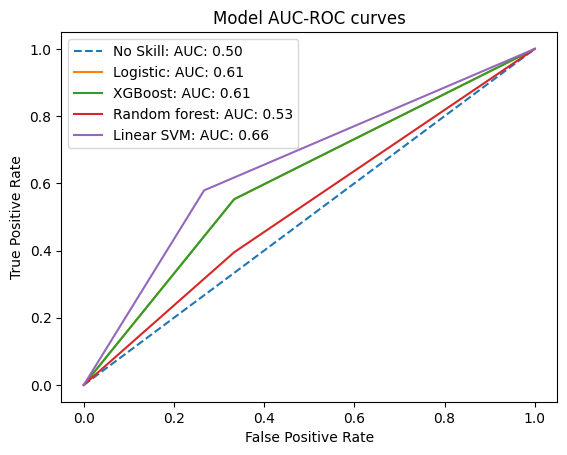

In [135]:
from sklearn.metrics import roc_curve, roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
ns_auc = roc_auc_score(y_test, ns_probs)

# PCA LogReg classifier AUC and ROC values
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_pred)
lr_auc = roc_auc_score(y_test, y_pred)


#PCA XGboost Classifier values
xg_fpr, xg_tpr, xg_thresholds = roc_curve(y_test, y_pred_xgb)
xg_auc = roc_auc_score(y_test, y_pred_xgb)

# PCA random forst classifier values
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_pred_task_rf)
rf_auc = roc_auc_score(y_test, y_pred_task_rf)

# PCA SVM values
svm_fpr, svm_tpr, svm_thresholds = roc_curve(y_test, y_pred_svm_task)
svm_auc = roc_auc_score(y_test, y_pred_svm_task)

#Plot all together
plt.plot(ns_fpr, ns_tpr, linestyle='--', label=f'No Skill: AUC: {ns_auc:.2f}')
plt.plot(lr_fpr, lr_tpr, marker='', label=f'Logistic: AUC: {lr_auc:.2f}')
plt.plot(xg_fpr, xg_tpr, marker='', label=f'XGBoost: AUC: {xg_auc:.2f}')
plt.plot(rf_fpr, rf_tpr, marker='', label=f'Random forest: AUC: {rf_auc:.2f}')
plt.plot(svm_fpr, svm_tpr, marker='', label=f'Linear SVM: AUC: {svm_auc:.2f}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Model AUC-ROC curves")
# show the legend
plt.legend()
# show the plot
plt.show()

# Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

# Silhouette Score Method
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tsne_result)
    silhouette_scores.append(silhouette_score(tsne_result, labels))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Using t-SNE results with perplexity=30 for clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(features)

# Perform K-means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(tsne_result)

# Add cluster labels to the run_mean DataFrame
run_mean['Cluster'] = labels

# Visualize the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title('t-SNE with K-means Clustering (k=3)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, orientation='horizontal', label='Cluster Label')
plt.grid(True)
plt.show()

# Analyze the clusters
cluster_summary = run_mean.groupby('Cluster')[['ACC', 'AVG_DIFFICULTY_LEVEL', 'MEDIAN_RT']].mean()
print(cluster_summary)

print('Cluster 0 (Cyan), Cluster 1 (Yellow), Cluster 2 (Purple)')

In [ ]:
# Describe the data to check for anomalies
print(run_mean.describe())

# Plot the features to check for anomalies
import seaborn as sns

sns.pairplot(run_mean, hue='Cluster')
plt.show()


In [ ]:
# Check for correlations
correlation_matrix = run_mean.corr()
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Drop one of each pair of highly correlated features if necessary
# For example, if ACC and AVG_DIFFICULTY_LEVEL are highly correlated, you might drop one.


In [ ]:
# Check for class imbalance
print(run_mean['Cluster'].value_counts())

# Visualize the class distribution
sns.countplot(x='Cluster', data=run_mean)
plt.title('Class Distribution')
plt.show()


# Autoencoder

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Assuming N_SUBJECTS and N_PARCELS are defined elsewhere

# Reshape fc array (choose your preferred method)
fc_reshaped = fc.reshape(N_SUBJECTS, -1)  # Flatten the entire connectivity matrix

# Define Autoencoder Model
class Autoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(input_shape=(fc_reshaped.shape[1],)),  # Adjust for your reshaping method
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(latent_dim, activation="relu"),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(fc_reshaped.shape[1]),  # Adjust for your reshaping method
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# Define Hyperparameters (adjust as needed)
latent_dim = 32  # Dimensionality of the latent space
epochs = 100
batch_size = 32

# Create the Autoencoder model
model = Autoencoder(latent_dim)

# Compile the model
model.compile(optimizer="adam", loss="mse")

# Train the model
model.fit(fc_reshaped, fc_reshaped, epochs=epochs, batch_size=batch_size)

# Extract Latent Features (optional)
latent_features = model.encoder.predict(fc_reshaped)
